In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)

In [4]:
# Reading Dataset
df_2018 = pd.read_csv("./hackathonGBDI_finalised/is-2018.csv", encoding= 'unicode_escape')
df_2019 = pd.read_csv("./hackathonGBDI_finalised/is-2019.csv", encoding= 'unicode_escape')
df_2020 = pd.read_csv("./hackathonGBDI_finalised/is-2020.csv", encoding= 'unicode_escape')
df_2021 = pd.read_csv("./hackathonGBDI_finalised/is-2021.csv", encoding= 'unicode_escape')
province_data = pd.read_excel("./hackathonGBDI_finalised/province_code.xlsx")

In [5]:
def preprocessing_raw_data(data_df_list, concat=True, column_rename_dict={'aplace': 'province_id'}, 
                           categorical_columns=['sex', 'occu', 'injby', 'injoccu', 'injp', 'injt', 'injfrom', 
                                                'risk1', 'risk2', 'risk3', 'risk4', 'risk5', 'mass_casualty']):
    """
    Returns a concatenated dataframe if concat is set to True; 
    otherwise it returns cleaned dataframes to be unpacked based on # list of dataframes provided
    """
    def subset_clean_dates(data_df, date_columns=['adate', 'hdate']):
        for date_column in date_columns:
            subset_data_df = data_df.query(f"{date_column} != '0/0/0 00:00:00'").copy()
            diff_rows = data_df.shape[0] - subset_data_df.shape[0]
            if diff_rows > 0:
                print(f"For {date_column} data, removing {diff_rows} rows of 0/0/0 00:00:00 found. ")
        return subset_data_df
    
    def renaming_column_names(data_df, column_rename_dict=column_rename_dict):
        return data_df.rename(columns=column_rename_dict).copy()
    
    new_dataframe_list = []
    i=0
    for dataframe in data_df_list:
        i += 1
        print(f"Processing number {i} dataset provided in dataframe list.")
        new_dataframe = pd.DataFrame()
        new_dataframe = subset_clean_dates(dataframe).copy()
        # Renaming of columns
        print("Renaming columns provided.")
        new_dataframe = new_dataframe.rename(columns={'aplace': 'province_id'}).copy()
        # Casting date columns to datetime
        for date_column in ['adate', 'hdate']:
            print(f"Converting {date_column} to datetime.")
            new_dataframe[date_column] = pd.to_datetime(new_dataframe[date_column], format='%d/%m/%Y %H:%M', errors = 'coerce')  
        # Categorize catogerical variables
        for cat_col in categorical_columns:
            new_dataframe[cat_col] = pd.to_numeric(new_dataframe[cat_col], errors='coerce')
            new_dataframe[cat_col] = new_dataframe[cat_col].astype('Int64')
            new_dataframe[cat_col] = new_dataframe[cat_col].astype('category')
        print("Casting of variables into categories completed!")
        new_dataframe_list.append(new_dataframe)
    if concat:
        data_df = pd.concat(new_dataframe_list)
        return data_df
    else:
        return tuple(new_dataframe_list)

processed_data_df = preprocessing_raw_data([df_2018, df_2019, df_2020, df_2021], True)
# df_2018_2, df_2019_2, df_2020_2, df_2021_2 = preprocessing_raw_data([df_2018, df_2019, df_2020, df_2021], False)

Processing number 1 dataset provided in dataframe list.
Renaming columns provided.
Converting adate to datetime.
Converting hdate to datetime.
Casting of variables into categories completed!
Processing number 2 dataset provided in dataframe list.
Renaming columns provided.
Converting adate to datetime.
Converting hdate to datetime.
Casting of variables into categories completed!
Processing number 3 dataset provided in dataframe list.
For hdate data, removing 3 rows of 0/0/0 00:00:00 found. 
Renaming columns provided.
Converting adate to datetime.
Converting hdate to datetime.
Casting of variables into categories completed!
Processing number 4 dataset provided in dataframe list.
For hdate data, removing 1 rows of 0/0/0 00:00:00 found. 
Renaming columns provided.
Converting adate to datetime.
Converting hdate to datetime.
Casting of variables into categories completed!


In [6]:
province_data['province_district_id'] = province_data['province_id']+province_data['district_id']
province_data['province_id'].nunique()
province_data['province_id'] = province_data['province_id'].astype(object)
province_data.info()
# processed_data_df.iloc[np.where(np.isin(processed_data_df['aplace'].unique(),province_data['province_id'].unique()))]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7433 entries, 0 to 7432
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   province_id           7433 non-null   object
 1   name_th               7433 non-null   object
 2   name_en               7433 non-null   object
 3   district_id           7433 non-null   int64 
 4   name_th_x             7433 non-null   object
 5   name_en_x             7433 non-null   object
 6   sub_dist_id           7433 non-null   int64 
 7   name_th_y             7433 non-null   object
 8   name_en_y             7093 non-null   object
 9   province_district_id  7433 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 580.8+ KB


In [7]:
# @interact
# def view_cat_col_distribution(cat_col=['sex', 'occu', 'injby', 'injoccu', 'injp', 'injt', 'injfrom', 'risk1', 'risk2', 'risk3', 'risk4', 'risk5', 'mass_casualty']):
#     plt.figure()
#     processed_data_df[cat_col].value_counts().plot(kind='bar')
#     plt.title(f"{cat_col}")

### Outcome 1:  
Data visualization to analyze trends of accidents, population at risk, risky times or seasons and possible factors of the accidents


In [8]:
def get_week_of_month(day_of_month):
    week_of_month_dict = {1: range(1, 8), 2: range(8, 15), 3: range(15, 22), 4: range(22, 29), 5: range(29, 32)}
    for key, item in week_of_month_dict.items():
        if day_of_month in item:
            return key

In [9]:
# Without outcome 1 in mind, we first subset only accidents อุบัติเหตุ from injby_option in data
data_df = processed_data_df.copy()
accidents_data_df = data_df.query("injby==1")
accidents_data_df['Year_adate'] = accidents_data_df['adate'].dt.year
accidents_data_df['Month_adate'] = accidents_data_df['adate'].dt.month
accidents_data_df['Day_adate'] = accidents_data_df['adate'].dt.day

accidents_data_df['province_id'] = pd.to_numeric(accidents_data_df['province_id'], errors='coerce')
accidents_data_df['province_id'] = accidents_data_df['province_id'].astype('Int64')

province_data['province_id'] = pd.to_numeric(province_data['province_id'], errors='coerce')
province_data['province_id'] = province_data['province_id'].astype('Int64')
province_data_main = province_data[['province_id', 'name_th', 'name_en']].drop_duplicates()

accidents_data_df['Year_Month_Day'] = pd.to_datetime(accidents_data_df["Year_adate"].astype(str) + "/" + accidents_data_df["Month_adate"].astype(str) + "/" + accidents_data_df["Day_adate"].astype(str))
accidents_data_df['Year_Month'] = pd.to_datetime(accidents_data_df["Year_adate"].astype(str) + "/" + accidents_data_df["Month_adate"].astype(str))

# Subsetting accidents_data_df whose province_id can be found in province_data
accidents_data_df_has_province = accidents_data_df[accidents_data_df['province_id'].isin(province_data_main['province_id'].unique())]
# Merging of accidents_data_df with province_data to get their province names in thai and english
accidents_data_df_has_province_merged = pd.merge(accidents_data_df_has_province, province_data_main, on='province_id')
sorted_accidents_data_df_has_province_merged = accidents_data_df_has_province_merged.groupby(['Year_adate', 'name_en'])[['hdate']].count().reset_index().sort_values(ascending=False, by=['Year_adate','hdate'])

accidents_data_df_has_province_merged['Week_adate'] = accidents_data_df_has_province_merged['Day_adate'].apply(lambda x: get_week_of_month(x))

In [10]:
@interact
def get_yearly_top_accidents_by_province(year=[2021, 2020, 2019, 2018, 'all'], top=[2,3,4,5]):
    data_df = sorted_accidents_data_df_has_province_merged.rename(columns={'Year_adate': 'Year', 'name_en': 'Name (English)', 'hdate': 'Number of accidents'})
    print(f"Displaying top {top} provinces with highest number of accidents in Year {year} ")
    if year == 'all':
        subset_df = data_df.groupby(['Year']).head(top)
        return subset_df
    else:
        year = int(year)
        subset_df = data_df.query(f"Year == {year}").head(top)
        top_provinces = subset_df['Name (English)'].unique()
        top_provinces_data_df = accidents_data_df_has_province_merged.loc[accidents_data_df_has_province_merged['name_en'].isin(top_provinces)]
        top_provinces_data_df_merged_gb = top_provinces_data_df.groupby(['Year_Month', 'name_en'])[['hdate']].count().reset_index()
        sns.lineplot('Year_Month', 'hdate', hue='name_en', data=top_provinces_data_df_merged_gb)
        return subset_df

interactive(children=(Dropdown(description='year', options=(2021, 2020, 2019, 2018, 'all'), value=2021), Dropd…

In [11]:
# Weekly, Daily or Monthly data
@interact
def view_accidents_trending(province=['all provinces']+list(accidents_data_df_has_province_merged['name_en'].unique()), 
                            data_freq=['Daily','Weekly', 'Monthly'], analyze_by=[
                                'sex', 'occu', 'injt', 'injfrom', 'risk1', 'risk2', 'risk3', 'risk4', 'risk5', 
                                'mass_casualty']):
    if province != 'all provinces':
        province_daily_df = accidents_data_df_has_province_merged.query(f"name_en == '{province}'")
    else:
        province_daily_df = accidents_data_df_has_province_merged.copy()
    province_daily_df_gb = province_daily_df.groupby(['Year_Month_Day'])[['hdate']].count().reset_index()
    
    # Make sure evenly spaced to daily data
    new_date_index = pd.date_range(province_daily_df_gb['Year_Month_Day'].min(), province_daily_df_gb['Year_Month_Day'].max())
    province_daily_df_gb = province_daily_df_gb.set_index('Year_Month_Day')
    province_daily_df_gb = province_daily_df_gb.reindex(new_date_index, fill_value=np.nan)

    province_weekly_df_gb = province_daily_df_gb.resample('W').sum().copy()
    province_monthly_df_gb = province_daily_df_gb.resample('M').sum().copy()
    
    if data_freq == 'Daily':
        plt.plot(province_daily_df_gb['hdate'])
        plt.title(f'Daily Accident Trending for {province}')
    elif data_freq == 'Weekly':     
        plt.plot(province_weekly_df_gb['hdate'])
        plt.title(f'Weekly Accident Trending for {province}')
    elif data_freq == 'Monthly':
        plt.plot(province_monthly_df_gb['hdate'])
        plt.title(f'Monthly Accident Trending for {province}')

    plt.figure()
    plt.title(f"Number of Accidents reported count by {analyze_by} from 2018 to 2021")
    province_daily_df[analyze_by].value_counts().plot(kind='bar')

interactive(children=(Dropdown(description='province', options=('all provinces', 'Chanthaburi', 'Phetchaburi',…

### Outcome 2:
Prediction of car accidents in each region for the next 5 years including recommendations on how to prevent car accidents

In [12]:
from scipy.optimize import minimize              # for function minimization
from dateutil.relativedelta import relativedelta # working with dates with style

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit

from itertools import product 
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [13]:
@interact
def exponential_smoothing_model(province=['all provinces']+list(accidents_data_df_has_province_merged['name_en'].unique()), 
                            data_freq=['Daily','Weekly', 'Monthly']):
    if province != 'all provinces':
        province_daily_df = accidents_data_df_has_province_merged.query(f"name_en == '{province}'")
    else:
        province_daily_df = accidents_data_df_has_province_merged.copy()
    province_daily_df_gb = province_daily_df.groupby(['Year_Month_Day'])[['hdate']].count().reset_index()
    # Make sure evenly spaced to daily data
    new_date_index = pd.date_range(province_daily_df_gb['Year_Month_Day'].min(), province_daily_df_gb['Year_Month_Day'].max())
    province_daily_df_gb = province_daily_df_gb.set_index('Year_Month_Day')
    province_daily_df_gb = province_daily_df_gb.reindex(new_date_index, fill_value=np.nan)

    province_weekly_df_gb = province_daily_df_gb.resample('W').sum().copy()
    province_monthly_df_gb = province_daily_df_gb.resample('M').sum().copy()
    
    if data_freq == 'Daily':
        modeling_dataset = province_daily_df_gb.copy()
    elif data_freq == 'Weekly':     
        modeling_dataset = province_weekly_df_gb.copy()
    elif data_freq == 'Monthly':
        modeling_dataset = province_monthly_df_gb.copy()

    def double_exponential_smoothing(series, alpha, beta):
        """
            series - dataset with timeseries
            alpha - float [0.0, 1.0], smoothing parameter for level
            beta - float [0.0, 1.0], smoothing parameter for trend
        """
        # first value is same as series
        result = [series[0]]
        for n in range(1, len(series)+1):
            if n == 1:
                level, trend = series[0], series[1] - series[0]
            if n >= len(series): # forecasting
                value = result[-1]
            else:
                value = series[n]
            last_level, level = level, alpha*value + (1-alpha)*(level+trend)
            trend = beta*(level-last_level) + (1-beta)*trend
            result.append(level+trend)
        return result

    def plotDoubleExponentialSmoothing(series, alphas, betas):
        """
            Plots double exponential smoothing with different alphas and betas

            series - dataset with timestamps
            alphas - list of floats, smoothing parameters for level
            betas - list of floats, smoothing parameters for trend
        """

        with plt.style.context('seaborn-white'):    
            plt.figure(figsize=(20, 8))
            for alpha in alphas:
                for beta in betas:
                    plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
            plt.plot(series.values, label = "Actual")
            plt.legend(loc="best")
            plt.axis('tight')
            plt.title("Double Exponential Smoothing")
            plt.grid(True)

    for alpha in [0.6, 0.7, 0.8, 0.9]:
        plotDoubleExponentialSmoothing(modeling_dataset.hdate, alphas=[alpha, 0.06], betas=[alpha, 0.06])


interactive(children=(Dropdown(description='province', options=('all provinces', 'Chanthaburi', 'Phetchaburi',…

In [14]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=5):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    nsplits = 3
    tscv = TimeSeriesSplit(n_splits=nsplits) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error) 
    return np.mean(np.array(errors))

def plotHoltWinters(model, series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_squared_error(series.values, model.result[:len(series)])
    plt.title("Mean Squared Error: {0:.2f}".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=2, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series), len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);


In [15]:
%%time
def optimizing_holt_with_plot(data, min_methods=['TNC'], next_n_preds=60):
    # initializing model parameters alpha, beta and gamma
    x = [0, 0, 0] 
    for method in min_methods:
        print(method)
        # Minimizing the loss function 
        opt = minimize(timeseriesCVscore, x0=x, 
                       args=(data, mean_squared_error), 
                       method=method, bounds = ((0, 1), (0, 1), (0, 1)))

        # Take optimal values...
        alpha_final, beta_final, gamma_final = opt.x
        print(alpha_final, beta_final, gamma_final)

        # ...and train the model with them, forecasting for the next 5 years (monthly)
        model = HoltWinters(data, slen = 5, 
                            alpha = alpha_final, 
                            beta = beta_final, 
                            gamma = gamma_final, 
                            n_preds = next_n_preds, scaling_factor = 2)
        model.triple_exponential_smoothing()
        plotHoltWinters(model, data, plot_intervals=True, plot_anomalies=True)

Wall time: 0 ns


In [16]:
@interact
def holt_modeling(province=['all provinces']+list(accidents_data_df_has_province_merged['name_en'].unique()), 
                  data_freq=['Daily','Weekly', 'Monthly'], opt_method= ['Powell', 'TNC', 'Nelder-Mead', 'CG', 'SLSQP', 'BFGS', 'L-BFGS-B'],
                  pred_next=[90, 60, 30, 10]):
    if province != 'all provinces':
        province_daily_df = accidents_data_df_has_province_merged.query(f"name_en == '{province}'")
    else:
        province_daily_df = accidents_data_df_has_province_merged.copy()
    province_daily_df_gb = province_daily_df.groupby(['Year_Month_Day'])[['hdate']].count().reset_index()
    # Make sure evenly spaced to daily data
    new_date_index = pd.date_range(province_daily_df_gb['Year_Month_Day'].min(), province_daily_df_gb['Year_Month_Day'].max())
    province_daily_df_gb = province_daily_df_gb.set_index('Year_Month_Day')
    province_daily_df_gb = province_daily_df_gb.reindex(new_date_index, fill_value=np.nan)

    province_weekly_df_gb = province_daily_df_gb.resample('W').sum().copy()
    province_monthly_df_gb = province_daily_df_gb.resample('M').sum().copy()
    
    if data_freq == 'Daily':
        modeling_dataset = province_daily_df_gb.copy()
        prediction_end_date = modeling_dataset.index.max() + timedelta(days=pred_next)
    elif data_freq == 'Weekly':
        pred_next_in_days = pred_next*7
        modeling_dataset = province_weekly_df_gb.copy()
        prediction_end_date = modeling_dataset.index.max() + timedelta(days=pred_next_in_days)
    elif data_freq == 'Monthly':
        pred_next_in_days = pred_next*30
        modeling_dataset = province_monthly_df_gb.copy()
        prediction_end_date = modeling_dataset.index.max() + timedelta(days=pred_next_in_days)
    
    print(f"{data_freq} predictions from {modeling_dataset.index.max()} to {prediction_end_date}.")
    optimizing_holt_with_plot(modeling_dataset.hdate,min_methods=[opt_method], next_n_preds=pred_next)

interactive(children=(Dropdown(description='province', options=('all provinces', 'Chanthaburi', 'Phetchaburi',…

## Executive Summary

### Analyzing accidents reported by region
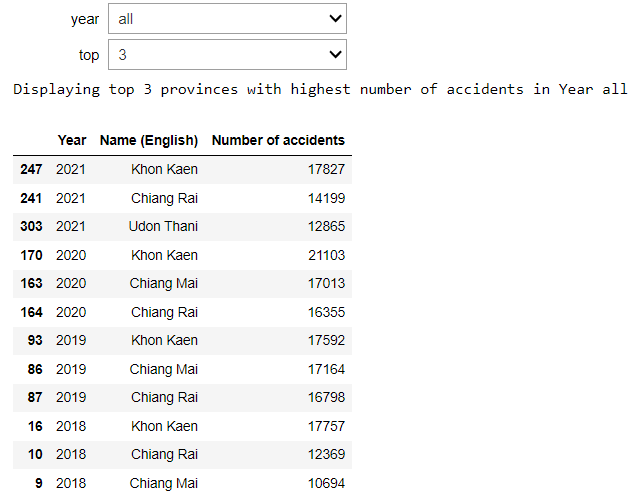

Geolocation between few cities that have high number of accidents reported. They're not close enough to each other to be drawing any clusters  
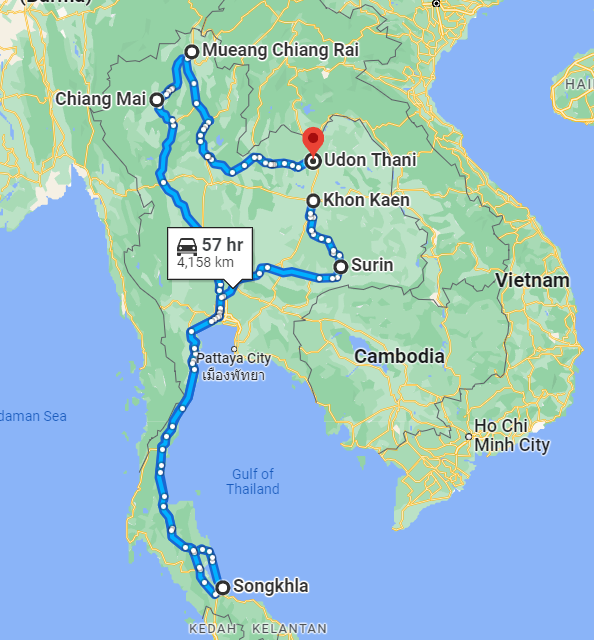 

#### Khoan Kaen, Chiang Rai, Chiang Mai has the highest reported number of accidents for 3 consecutive years from 2018 to 2020. Chiang Mai has not appeared as top 3 in 2021 which might suggest that government officials have preventative measures in Chiang Mai.  

#### It is rather surprising to observe that Chiang Rai still remained top 3 in 2021 even though by Chiang Mai is the closest province by proximity. 

#### When comparing accidents reported across gender, occupation, type of vehicle involved, alcohol consumption, drug consumption of injured person, safety measures taken by injured person, cell phone usage of injured person, it is generally found that the following population has relatively higher number of accidents reported in the past 4 years:

1. Males (relative to Females)
2. Labourer, Student and Unemployed (relative to other occupations)
3. Motorbike and bike (relative to other types of vehicles like sedan)
4. Vehicle overturned or fell off road as well as accidents involving motorbike (relative to other means of injuries)
5. Not taking safety measures like putting on safety belt

#### Most of the accidents reported that stakeholder involved in accidents hadn't consumed alcohol, drug, use cell phone during traveling. However, this does not mean that consumption of alcohol, drug and cell phone are encouraged when commuting.
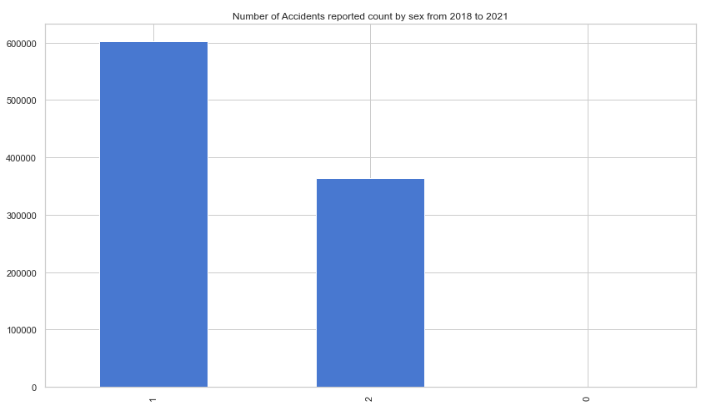

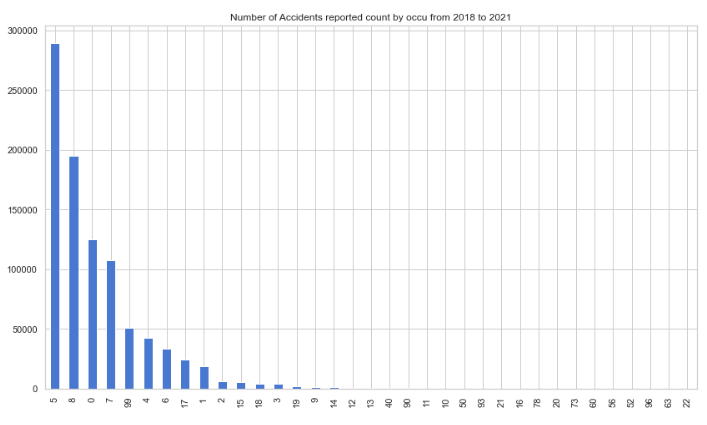

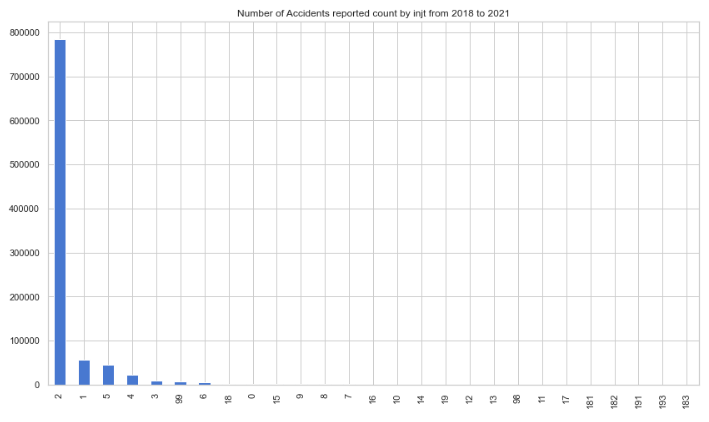

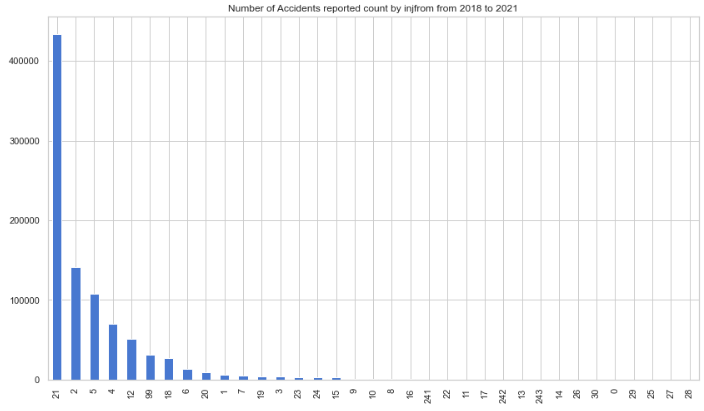

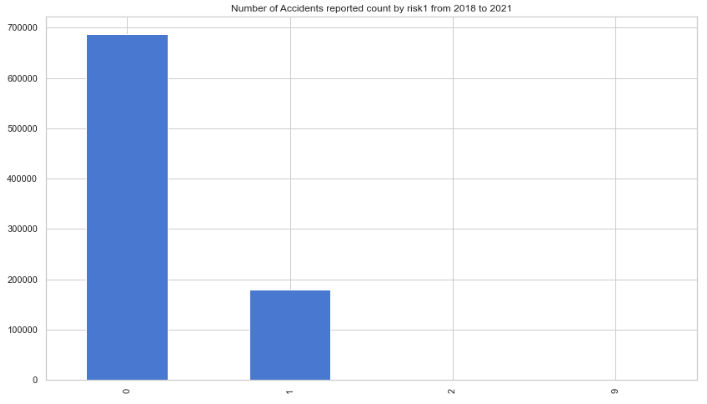

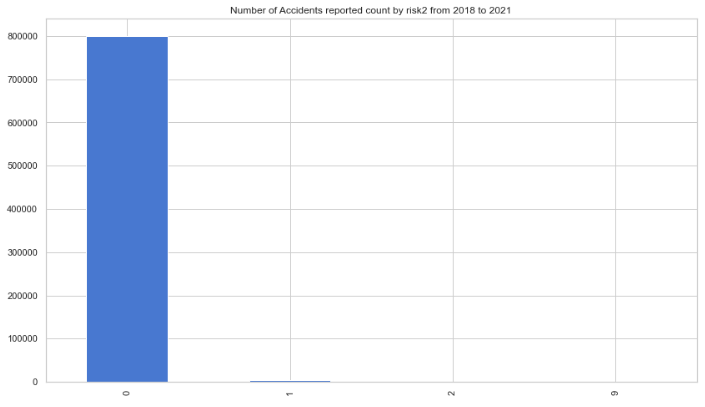

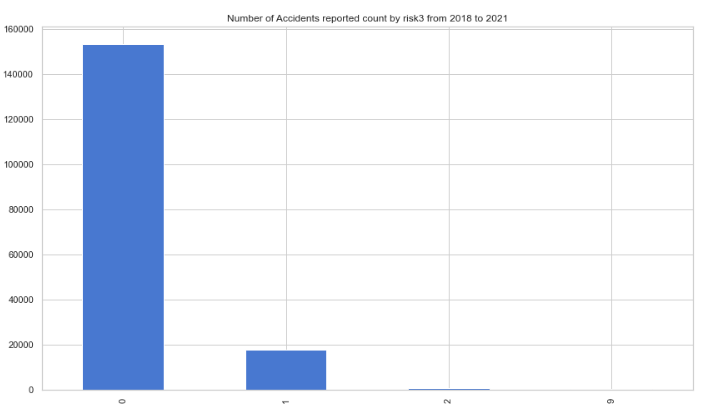

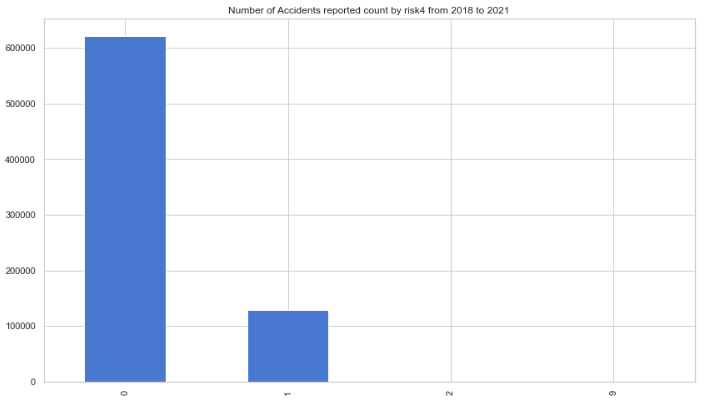

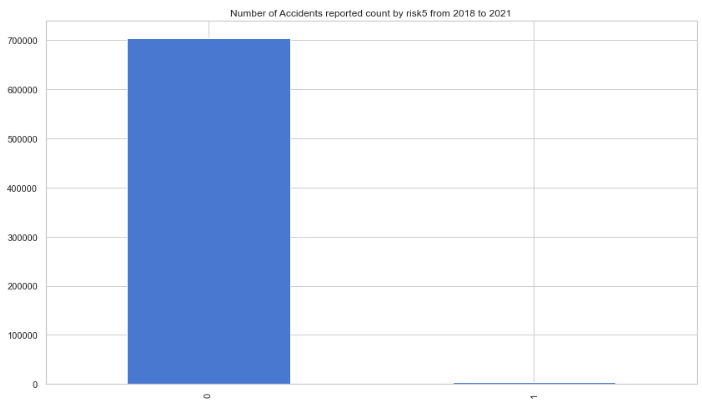

### Modeling trends of accidents

#### In this use case, accidents in Thailand by region are modeled using time series modeling. 

Multiple smoothing effects, modeling techniques have been tested out but only of them are included in this production website due to simplicity and performances. They are:

- Double exponential smoothing modeling
- Triple exponential (Holt-Winters model with the anomalies detection using Brutlag method)

User of this dashboard has the flexibility to choose whether they want to model:
1. Daily, Weekly or Monthly
2. By Province or all provinces
3. Predict next N time (daily, weekly or monthly)
4. Further select which optimization method they want to use 

An example of analysis below is done on Daily data for all province, predicting 60 days ahead using Powell optmization method.

Documentation on optimization method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

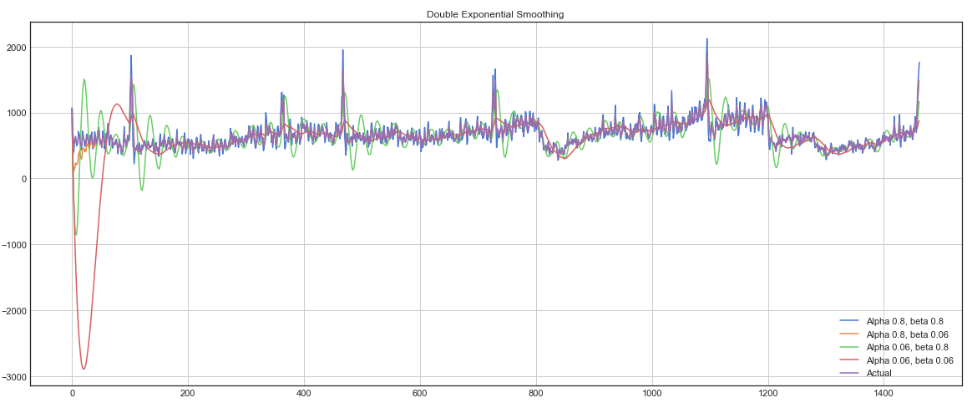

#### Double exponential smoothing with alpha 0.8 and beta 0.06 seem to be able to capture most of the trends

Note: Prior to this, stationarity check was done using DF test. Examining the seasonality, trends and white noises of trending has been done through acf and pacf.

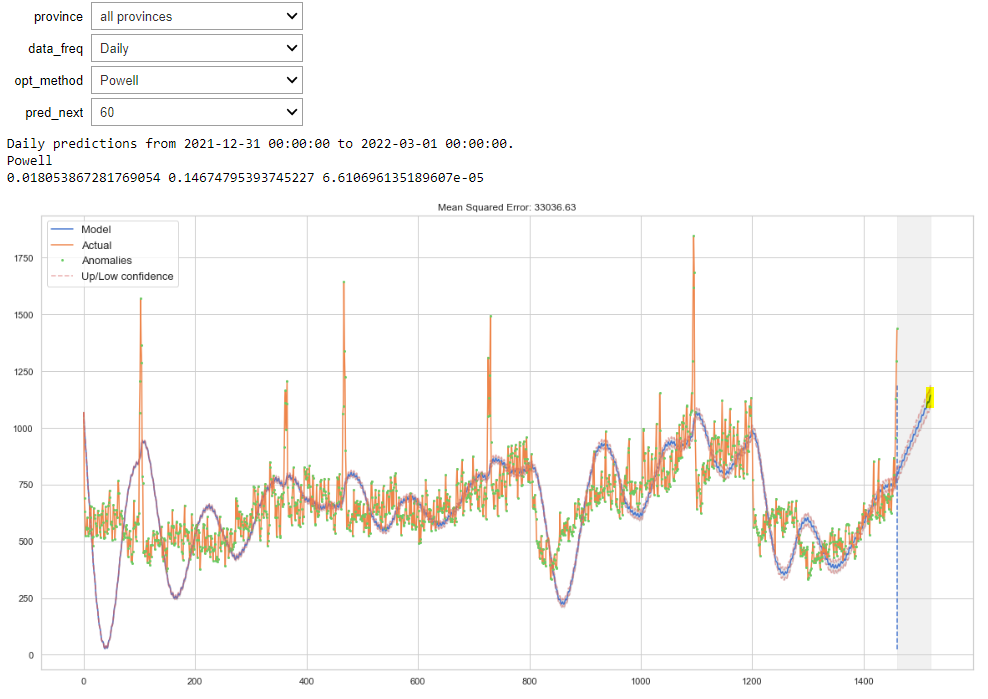

#### In the most general sense, the model above shows that there would be an upward trending of accidents to be reported from 2021-12-31 to 2022-03-01 (60 days), peaking near 1300 cases on a daily basis on 2022-03-01. 

#### Challenges and Limitations:

1. Model Performances:  
    - Models above can be further fine tuned using different minimization methods as well as seasonality and autoregressive parameters 
2. Feature Engineering:  
    - Rather than using time series modeling, new features (external factors like humidity in that province, initiatives by government officials to bring down accident rates, daily traffic in that province etc) can be added into the dataset and be modeled as a multivariate time series model or regression problem. Note: There was an attempt done to model it through linear regression where features are generated based on lagging of its own features but performance of the model is worse than the above. 

### Appendix

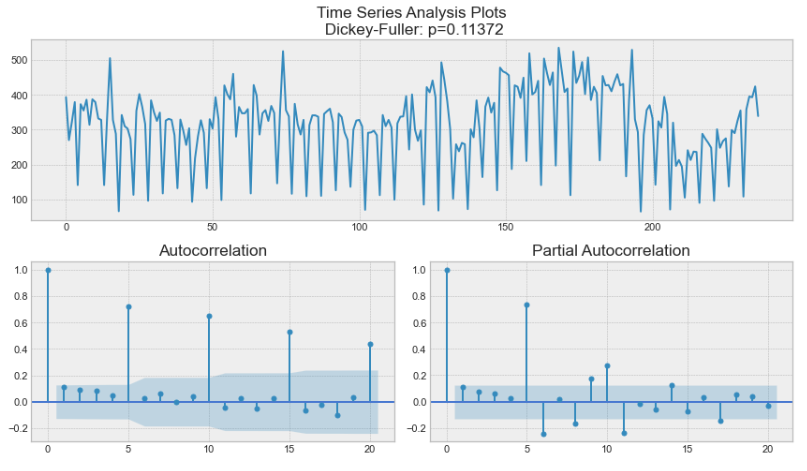  

Example of DF-test on daily data. Plot above shows a seasonality of around every 5 days.

An attempt remove seasonality as follow:  
modeling_dataset_diff = modeling_dataset.hdate - modeling_dataset.hdate.shift(5)  

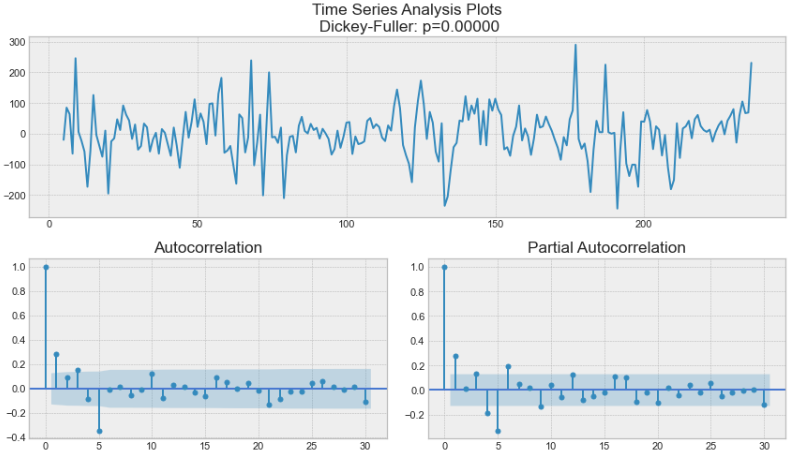  
Now, p-value < 0.05 indicating time series is non-stationary.  